## yt profiles with dask 

One the many ways to use yt to analyze a dataset is through creating a [profile](https://yt-project.org/doc/visualizing/plots.html#d-profile-plots), which is yt-speak for a binned statistic of a field. yt's implemenation allows the user to supply the binning field, multiple fields-to-be-binned and a field to use as a weight. Addtionally you can bin by multiple fileds AND it all works in parallel with MPI! For example, we can find the unweighted summation of the temperature field binned by density with:



yt : [INFO     ] 2020-12-23 14:29:57,620 Parameters: current_time              = 230.66527489234
yt : [INFO     ] 2020-12-23 14:29:57,621 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-12-23 14:29:57,621 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-12-23 14:29:57,621 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-12-23 14:29:57,622 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-12-23 14:29:57,622 Parameters: current_redshift          = -2.7810863612032e-09
yt : [INFO     ] 2020-12-23 14:29:57,623 Parameters: omega_lambda              = 0.727
yt : [INFO     ] 2020-12-23 14:29:57,623 Parameters: omega_matter              = 0.273
yt : [INFO     ] 2020-12-23 14:29:57,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-12-23 14:29:57,624 Parameters: hubble_constant           = 0.702
Parsing Hierarchy : 100%|██████████| 211/211 [00:00<00:00, 19845.68it/s]
yt : [INFO     ] 2020-1


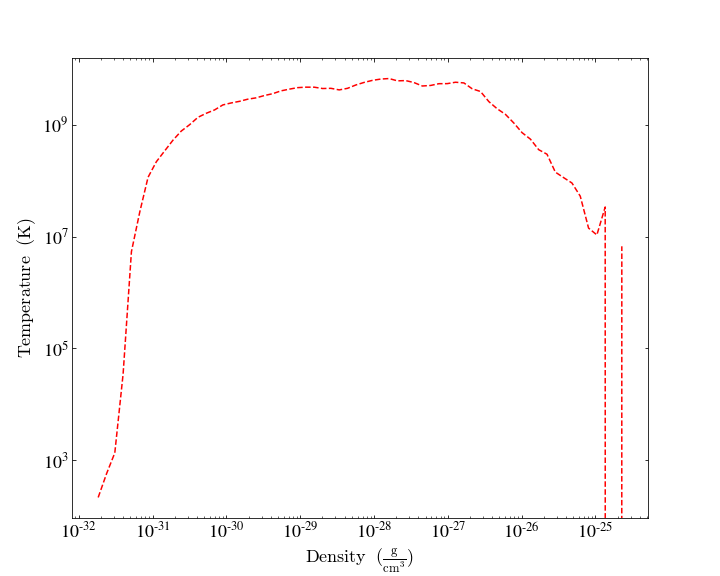

In [1]:
import yt

ds = yt.load("enzo_tiny_cosmology/DD0046/DD0046")
ad = ds.all_data()
plot = yt.ProfilePlot(ad, "density", ["temperature"],
                   weight_field=None,
                   plot_spec=dict(color='red', linestyle="--"))
plot.show()


The profile creation is one of the sections of yt's codebase that uses chunk-iteration to iteratively access data and so it's one of the areas I've been looking into for adding correspodning Dask functionality. Towards that end, in this notebook, I explore some ways to calculate profiles for yt data with dask. I start off with a naive approach that is quick to code but fairly limited and then demonstrate how to construct a dask graph that utilizes yt's binning function directly.

### To run this notebook, you'll need: 
* yt
* dask. The graph visualizations below also require some setup ([see here](https://docs.dask.org/en/latest/graphviz.html)) and the final bit utilizes [`Dask.distributed`](https://distributed.dask.org/en/latest/).


### mimicking a dask-yt IO 

So let's start with the data! In this notebook, I'm going to pretend that yt's IO can efficiently return dask arrays, so let's start by setting up a simple function to return dask arrays from a yt region:

In [2]:
import dask.array as da
import numpy as np

def load_yt_da(field,chunksize=50000):
    return da.from_array(ad[field].value,chunks=chunksize)

T = load_yt_da('temperature')
d = load_yt_da('density')
cell_mass = load_yt_da('cell_mass')
T

dask.array<array, shape=(231848,), dtype=float64, chunksize=(50000,), chunktype=numpy.ndarray>

## an initial naive approach with dask.array.digitize

Ok, so a binned statistic is a generalization of a histogram -- you bin one variable and then calculate a statistic on a second variable within each bin (rather than simply counting the number of observations within a bin as for a histogram).

Dask actually has a numpy-like implentation of [`histogram`](https://docs.dask.org/en/latest/array-api.html#dask.array.histogram) and so maybe we could use that as a recipe to write a dask implementation of [`scipy.stat.sbinned_statistic`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html) but let's start even simpler. Using dask's implementation of [`digitize`](https://docs.dask.org/en/latest/array-api.html#dask.array.digitize), we can manually bin our data and then use the resulting dask array of indeces to compute some statistics.

So let's start by creating a binning array for density and finding the digitized array:

In [3]:
mn = d.min().compute()
mx = d.max().compute()
nbins = 64
d_bins = np.logspace(np.log10(mn),np.log10(mx),nbins+1)

indxs = da.digitize(d,d_bins)
indxs

dask.array<digitize, shape=(231848,), dtype=int64, chunksize=(50000,), chunktype=numpy.ndarray>

To compute the equivalent of the profile above, we want to sum over each bin.  To sum over a single bin, we would do:

In [4]:
single_bin = T[indxs == 10].sum()
single_bin

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

since we're working with dask here, we've only constructed a task graph. Let's visualize the graph!

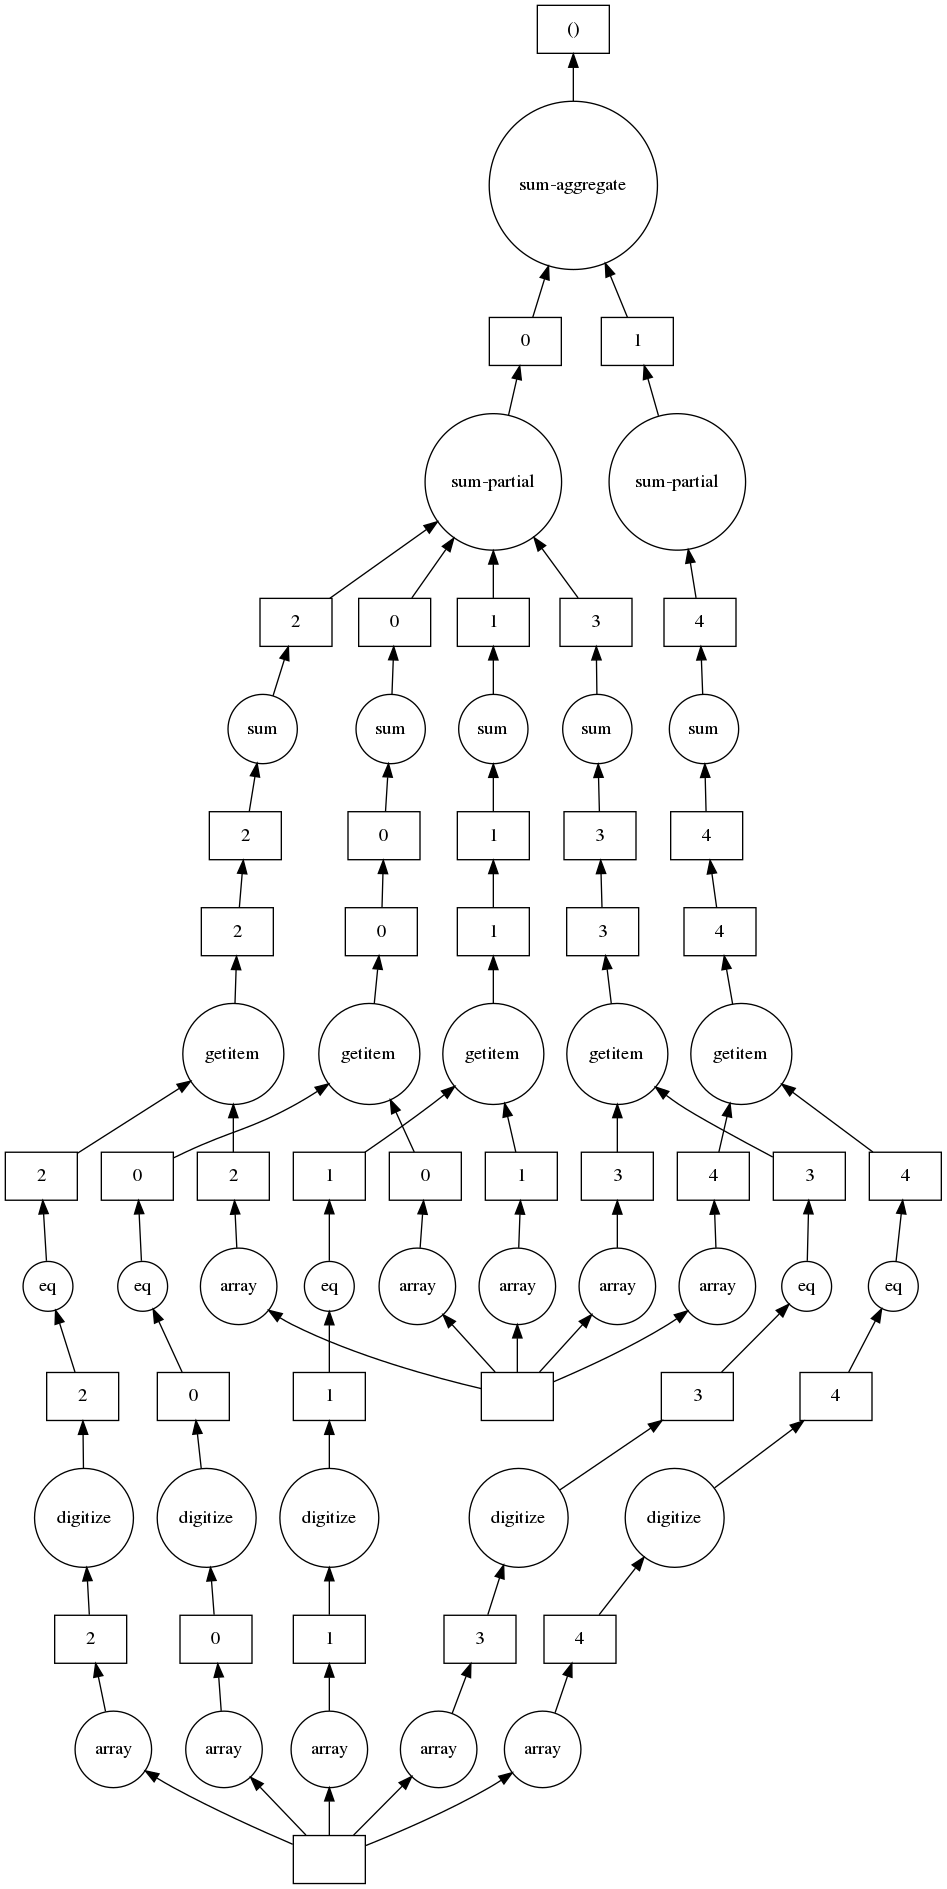

In [5]:
single_bin.visualize()

Yikes! That's pretty complex for a conceptually simple problem. What's happening here is that each chunk of the dask array can contain all the bins, so to find a single bin, we have to communicate across all the chunks to collect the right values to sum. 

And we need to do this for every bin! 

Well... let's do it:

In [6]:
binned_T = np.array([da.sum(T[indxs == i]).compute() for i in range(0,len(d_bins))])


and plot it:

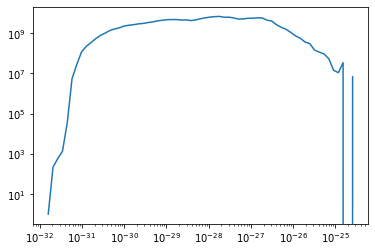

In [7]:
import matplotlib.pyplot as plt 
plt.loglog(d_bins,binned_T)

comparing to our previous profile, we can see it's very close, but (weirdly) not an exact match:


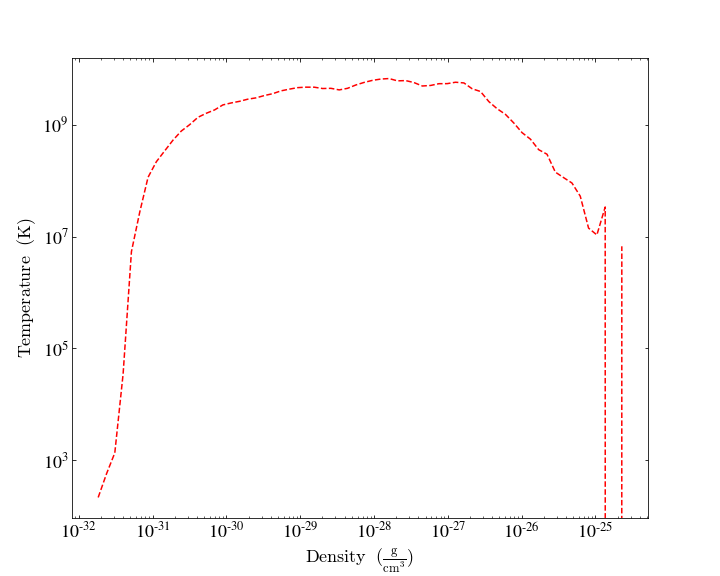

In [8]:
plot = yt.ProfilePlot(ad, "density", ["temperature"],
                   weight_field=None,
                   plot_spec=dict(color='red', linestyle="--"))
plot.show()

I'm not sure why exactly they don't match (I suspect small differences in how values are binned but haven't verified). 

In any case, our dask binning and summing here is pretty slow:

In [9]:
%%timeit
binned_T = np.array([da.nansum(T[indxs == i]).compute() for i in range(0,len(d_bins))])

388 ms ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Not great. Also, it's not clear how to extend this approach -- how do we add a weighting field? Additionally, for every field we want to bin we'd have to re-run this as opposed to yt's implementation which cleverly calculates all the fields within a single traversal of the data. So let's look at a better approach:


## Directly using yt's binning functions with dask! 

While the above approach is quick to code it has some downsides: binning several fields requires slicing and aggregating for each field, dask needs to communicate the digitized indeces across chunks and adding weighting functions would require some less trivial coding. yt's profiling tools are well optimized for parallel usage, so it'd be great to be able to make use of those functions **with** dask.  

There are a number of possible ways to approach this problem. I started looking into the `map_blocks` method available to Dask arrays, which will apply a function to each chunk. But I ran into issues because to match yt's efficiency in aggregating across chunks, I needed multiple outputs from my function, which is not currently supported by `map_blocks` (per discussion [here](https://github.com/dask/dask/issues/72) and [here](https://github.com/dask/dask/issues/1887)).

One thing we **can** do (as mentioned in the the discussion [here](https://github.com/dask/dask/issues/72)) is convert the arrays to dask `delayed` objects and then iterate over the chunks manually to construct an appropriate dask graph.

We can convert to a delayed object with

In [10]:
T_del = T.to_delayed()
T_del

array([Delayed(('array-388ceb16f3da900b3281280da1a81e11', 0)),
       Delayed(('array-388ceb16f3da900b3281280da1a81e11', 1)),
       Delayed(('array-388ceb16f3da900b3281280da1a81e11', 2)),
       Delayed(('array-388ceb16f3da900b3281280da1a81e11', 3)),
       Delayed(('array-388ceb16f3da900b3281280da1a81e11', 4))],
      dtype=object)

In [11]:
d_del = d.to_delayed()
d_del

array([Delayed(('array-747ea814f7ee4bab54bdafb794c83b5d', 0)),
       Delayed(('array-747ea814f7ee4bab54bdafb794c83b5d', 1)),
       Delayed(('array-747ea814f7ee4bab54bdafb794c83b5d', 2)),
       Delayed(('array-747ea814f7ee4bab54bdafb794c83b5d', 3)),
       Delayed(('array-747ea814f7ee4bab54bdafb794c83b5d', 4))],
      dtype=object)

and then loop over the chunks with, for example:

In [12]:
ops = []
for T_i,d_i in zip(T_del,d_del):
    ops.append((T_i * d_i).sum())

then to execute the graph, we call `dask.compute` manually:

In [13]:
from dask import compute 

In [14]:
f = compute(*ops)

In [15]:
f

(3.427063566721897e-17,
 1.7642346722672794e-17,
 2.6396449113575092e-17,
 4.095365412319823e-17,
 2.6359160491963057e-17)

So this gives a nice roadmap to constructing our binned statistic method. In pseudocode:

```python

field_to_bin,binning_field, weighting_field = get_dask_delayed()

ops = []
for fdata,bdata,wdata in zip(field_to_bin,binning_field, weighting_field ):
    ops.append(bin_a_single_chunk(fdata,bdata,wdata)

binned_chunks = compute(*ops)
aggregated_statistic = aggregate_the_chunks(binned_chunks)
```

This sort of reduction is actually **very** similar to how yt creates a profile. Intermediate statitsics for each chunk are calculated separately (by separate processors if using MPI) and then the chunks are aggregated. The binned statistics for each chunk are comprised of fairly small numpy arrays, so in our approach, we'll get our binning results into memory (`binned_chunks = compute(*ops)`) and then aggregate (rather than trying to write a dask reduction function). 

So what we need to do this is a function to calculate the statistics for each chunk and then a function to aggregate all the chunks. To do this we're going to mimic yt's `Profile1D` class from `yt.objects.profiles` and actually directly use the optimized cython function `yt.utilities.lib.misc_utilities.new_bin_profile1d` to calculate the statistics for each chunk. 

Ok, so let's first create a function that takes dask arrays as inputs and returns our delayed chunks, similar to our pseudocode above:

In [16]:
from dask import delayed
def create_profile(field_to_bin,binnning_field, bin_ranges, weighting_field = None, N_bins = 64, logbin = True):
    # returns a list of delayed chunk-stats
    
    # convert arrays to delayed objects! 
    f_d = field_to_bin.to_delayed()
    b_d = binnning_field.to_delayed()    
    if weighting_field is None:
        w_d = [None] * len(f_d)
    else:
        w_d = weighting_field.to_delayed() 
        
    bins_edges, bin_centers = get_bins(bin_ranges,N_bins,logbin)
    
    # the by-chunk binning:
    binned_chunks = [] 
    for field_chunk, bin_chunk, w_chunk in zip(f_d,b_d,w_d):
        binned_chunks.append(delayed(bin_a_chunk)(field_chunk,bin_chunk,bins_edges, weighting_field=w_chunk))        

    return binned_chunks

now let's create a function to create the bins we want to use (given the `bin_ranges` and `N_bins` input):

In [17]:
def get_bins(bin_ranges,N_bins = 64,logbin = True):
    if logbin:
        binfunc = getattr(np,'logspace')
        bin_ranges = [np.log10(binval) for binval in bin_ranges]
    else:
        binfunc = getattr(np,'linspace')    
    bin_edges = binfunc(bin_ranges[0],bin_ranges[1],N_bins+1)
    bin_centers = binfunc(bin_ranges[0],bin_ranges[1],N_bins)
    return bin_edges, bin_centers

Ok, the `bin_a_chunk` function is where we actually bin each chunk. This function follows yt's `Profile1D` class closely. It returns a `yt.data_objects.profiles.ProfileFieldAccumulator`, which is a simple container holding the intermediate stats for each bin.

In [18]:
from yt.data_objects.profiles import ProfileFieldAccumulator
from yt.utilities.lib.misc_utilities import new_bin_profile1d

def bin_a_chunk(field_to_bin, binning_field, bins, weighting_field = None):
    # binning_field : the current chunk of the field that we are binning BY
    # field_to_bin : the current chunk of the field that we want to bin     
    # bins : the bins we want to use for binning
    # weighting_field : the field to weight by
    #
    # returns ProfileFieldAccumulator for this chunk
           
    
    bin_ind = np.digitize(binning_field, bins) - 1 
    if weighting_field is None:
        weighting_field = np.ones(field_to_bin.shape, dtype=field_to_bin.dtype) 
            
    if field_to_bin.ndim == 1:
        fdata = field_to_bin[:,np.newaxis] # new_bin_profile1d expects 2d! go from (N,) to (N,1)! 
    else:
        fdata = field_to_bin
        
    n_fields = 1 # only 1 for now! 
    binned_sizes = (bins.size - 1,)
    temp_storage = ProfileFieldAccumulator(n_fields, binned_sizes)    

    # profile this chunk!
    new_bin_profile1d(
        bin_ind,
        weighting_field,
        fdata,
        temp_storage.weight_values,
        temp_storage.values,
        temp_storage.mvalues,
        temp_storage.qvalues,
        temp_storage.used,
    )              
    
    # modified from yt.data_objects.profiles.ProfileND._finalize_storage:    
    for i in range(n_fields):
        # q values are returned as q * weight but we want just q
        temp_storage.qvalues[..., i][
            temp_storage.used
        ] /= temp_storage.weight_values[temp_storage.used]
        
    return temp_storage

So at this point, we can actually run our code! Let's bin temperature by density again:

In [19]:
bin_ranges = [d.min().compute(), d.max().compute()]
bin_ranges[0] = bin_ranges[0] - 0.000001*bin_ranges[0] 
bin_ranges[1] = bin_ranges[1] + 0.000001*bin_ranges[1]
binned_chunks = create_profile(T,d,bin_ranges)

The offsetting of `bin_ranges` above solved a frustraing issue I was having for a while, and I discuss it [below](#what's-with-those-density-bins?). Ignore it for now!

So at this point we still only have a collection of dask graphs. But let's visualize it:

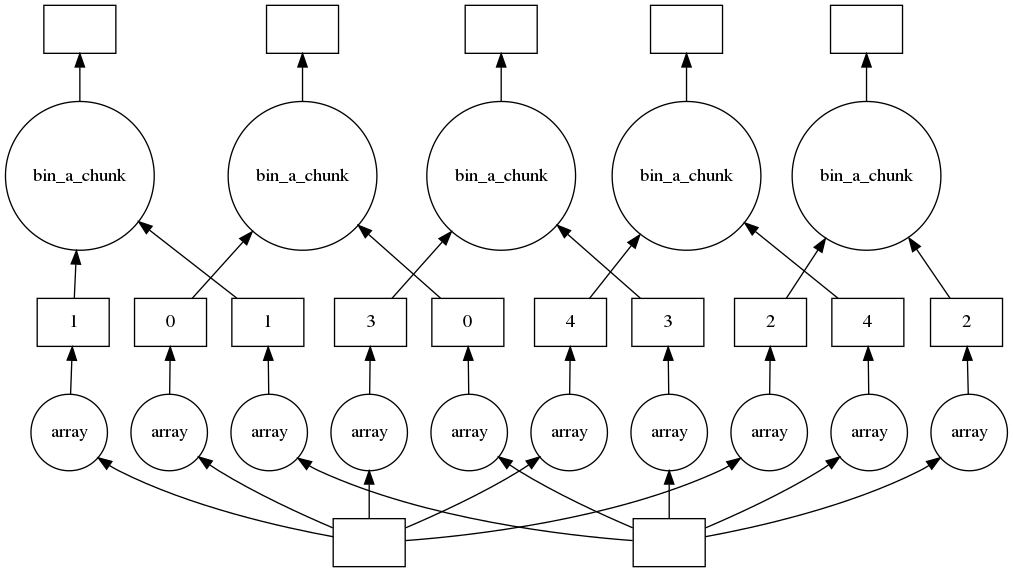

In [20]:
from dask import visualize
visualize(*binned_chunks)

That's **so** much simpler than the first naive approach. The main advantage is that we digitize each chunk separately and immediately use the digitized indices! So each of our arrays passes its chunk but after that there is **no communication** between chunks!

Ok, let's compute:

In [21]:
binned_chunks = compute(*binned_chunks)

so what we get out is a list of `ProfileFieldAccumulator` objects:

In [22]:
binned_chunks[0]

In [23]:
binned_chunks[0].__dict__.keys()

dict_keys(['values', 'mvalues', 'qvalues', 'used', 'weight_values'])

In [24]:
binned_chunks[0].qvalues.shape

(64, 1)

In [25]:
binned_chunks[0].qvalues[0:10]

array([[0.00000000e+00],
       [0.00000000e+00],
       [1.12448320e+00],
       [4.98946338e+03],
       [1.41719157e+08],
       [1.57084912e+09],
       [1.16446059e+10],
       [2.91610438e+10],
       [4.09067208e+10],
       [5.04628604e+10]])

Each of these arrays is 64 elements long (because we made used 64 bins in their construction) and contain all of the relant statisics for each bin that are needed to aggregate the bins.

So all we need to do is combine the chunks in the right way, which is exactly what `yt.data_objects.profiles.ProfileND._finalize_storage` does! Since `_finalize_storage` is a class method, for this demonstrating I simply copied that function and simplified it (removing mostly MPI-related communications): 

In [26]:
def finalize_storage(binned_chunks):
     
    # init the global store (mimicking an MPI rank-dict)
    all_store = {i:temp_storage for i,temp_storage in enumerate(binned_chunks)}        

    # init the aggregate storage
    temp_storage = binned_chunks[0]
    all_val = np.zeros_like(temp_storage.values)
    all_mean = np.zeros_like(temp_storage.mvalues)
    all_std = np.zeros_like(temp_storage.qvalues)
    all_weight = np.zeros_like(temp_storage.weight_values)
    all_used = np.zeros_like(temp_storage.used, dtype="bool")
    n_fields = all_std.shape[1] # again cause this is only for the binning and binned field...
    
    # Combine the weighted mean and standard deviation from each processor.
    # For two samples with total weight, mean, and standard deviation
    # given by w, m, and s, their combined mean and standard deviation are:
    # m12 = (m1 * w1 + m2 * w2) / (w1 + w2)
    # s12 = (m1 * (s1**2 + (m1 - m12)**2) +
    #        m2 * (s2**2 + (m2 - m12)**2)) / (w1 + w2)
    # Here, the mvalues are m and the qvalues are s**2.
    for p in sorted(all_store.keys()):
        all_used += all_store[p].used
        old_mean = all_mean.copy()
        old_weight = all_weight.copy()
        all_weight[all_store[p].used] += all_store[p].weight_values[
            all_store[p].used
        ]
        for i in range(n_fields):
            all_val[..., i][all_store[p].used] += all_store[p].values[..., i][
                all_store[p].used
            ]

            all_mean[..., i][all_store[p].used] = (
                all_mean[..., i] * old_weight
                + all_store[p].mvalues[..., i] * all_store[p].weight_values
            )[all_store[p].used] / all_weight[all_store[p].used]

            all_std[..., i][all_store[p].used] = (
                old_weight
                * (all_std[..., i] + (old_mean[..., i] - all_mean[..., i]) ** 2)
                + all_store[p].weight_values
                * (
                    all_store[p].qvalues[..., i]
                    + (all_store[p].mvalues[..., i] - all_mean[..., i]) ** 2
                )
            )[all_store[p].used] / all_weight[all_store[p].used]

    all_std = np.sqrt(all_std)
    return all_val, all_mean, all_std 

In [27]:
binned_sum, binned_mean, binned_std = finalize_storage(binned_chunks)

nice! now we our binned values from all our chunks!

In [28]:
binned_sum[0:10]

array([[2.17000000e+02],
       [5.73151995e+02],
       [1.35858635e+03],
       [3.50510224e+04],
       [5.36614434e+06],
       [2.73093093e+07],
       [1.14636383e+08],
       [2.17447799e+08],
       [3.39357923e+08],
       [5.27834399e+08]])

which we can plot, using our bin center values:

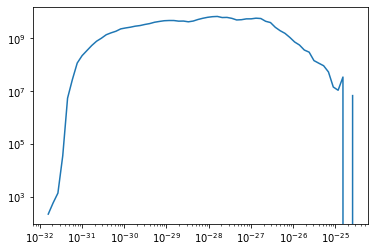

In [29]:
import matplotlib.pyplot as plt
bins_edges, bin_centers = get_bins(bin_ranges)
plt.loglog(bin_centers,binned_sum)

which exactly matches what we get from yt:


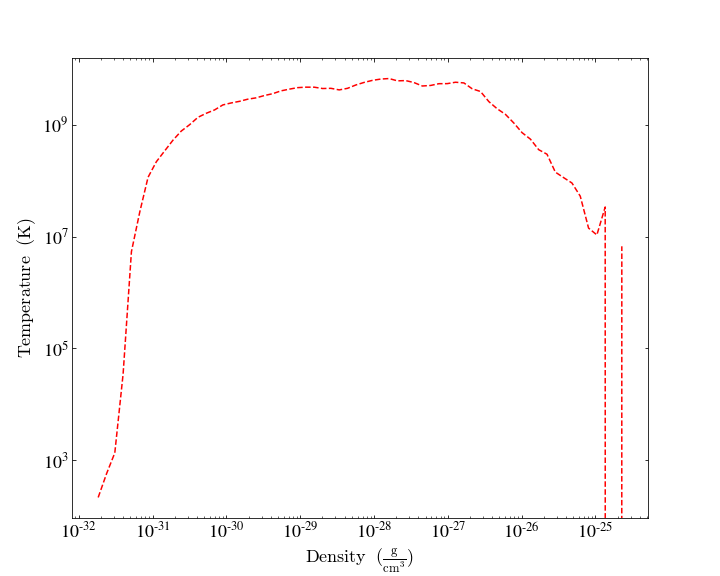

In [30]:
plot = yt.ProfilePlot(ad, "density", ["temperature"],
                   weight_field=None,
                   plot_spec=dict(color='red', linestyle="--"))
plot.show()

It's also **quite** fast -- a factor of 100 faster than the naive digitizing approach:

In [31]:
%%timeit
binned_chunks = create_profile(T,d,bin_ranges)
binned_chunks = compute(*binned_chunks)
binned_sum, binned_mean, binned_std = finalize_storage(binned_chunks)

4.25 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**AND** we can use a weighting field without complicating our dask graph much. To calculate the mean temperature (weighted by cell mass) vs density:

In [32]:
binned_chunks = create_profile(T,d,bin_ranges,weighting_field = cell_mass)
bins, bin_c = get_bins(bin_ranges)

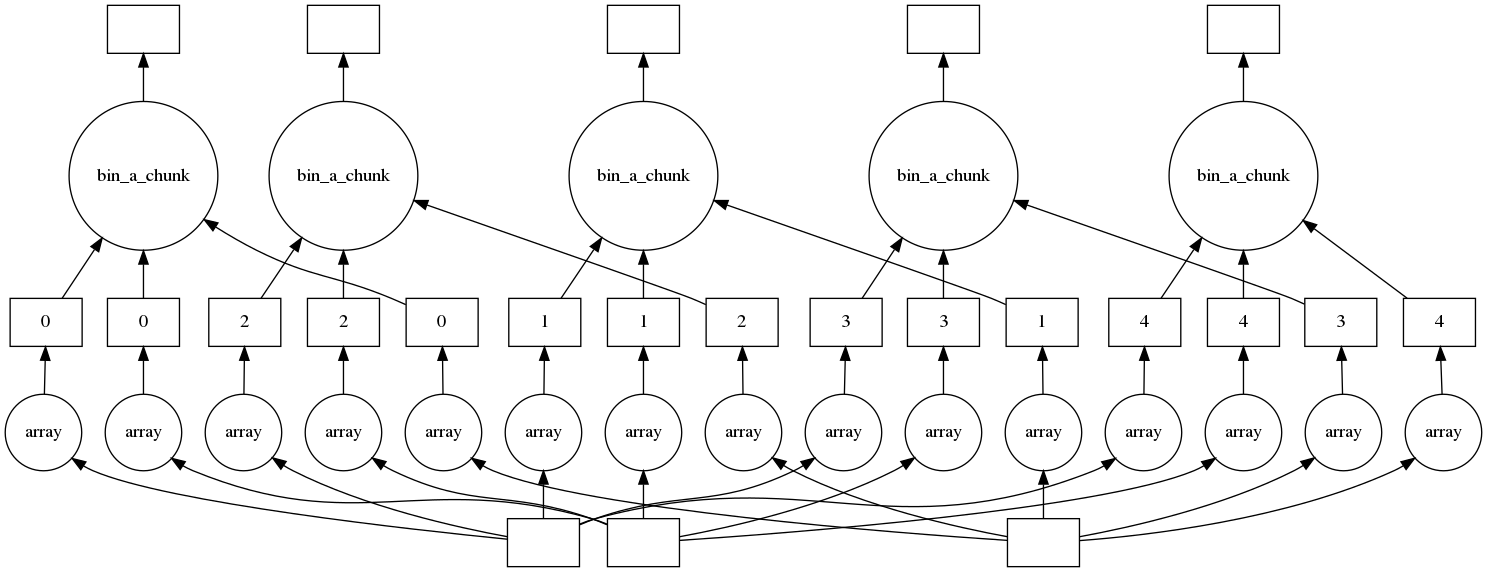

In [33]:
from dask import visualize
visualize(*binned_chunks)

We've just added another chunk to pass, after which our chunk-calculations are independent! 

Let's compute, aggregate our chunks then plot:

In [34]:
computed_bins = compute(*binned_chunks)

In [35]:
binned_sum, binned_mean, binned_std = finalize_storage(computed_bins)

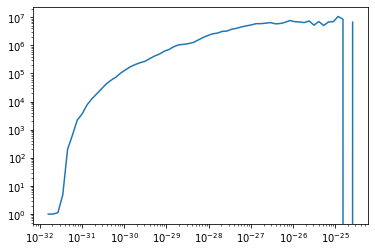

In [36]:
plt.loglog(bin_c,binned_mean[:,0])

and comparing to yt:


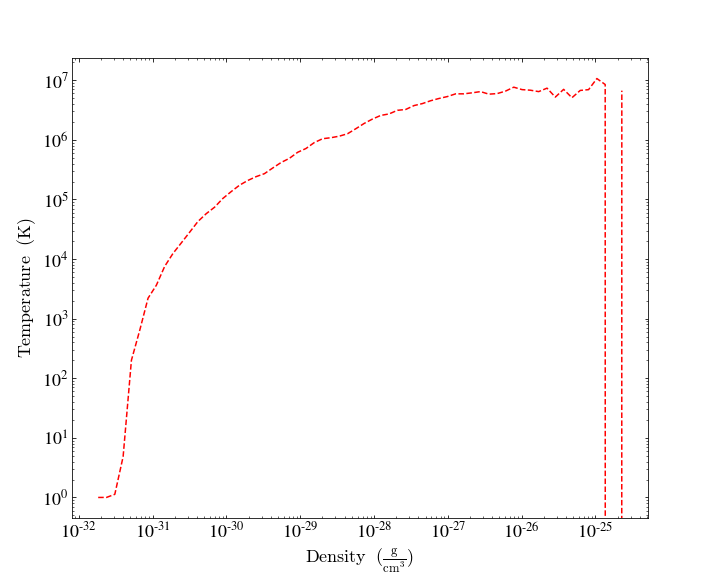

In [37]:
plot = yt.ProfilePlot(ad, "density", ["temperature"],
                   weight_field="cell_mass",
                   plot_spec=dict(color='red', linestyle="--"))
plot.show()

Neat-o! 

And because we're using dask arrays, to do this in parallel is as easy as spinning up a `dask.distributed.Client`:

In [38]:
from dask.distributed import Client

In [39]:
c = Client(threads_per_worker=1,n_workers=4)

In [40]:
c

Client Scheduler: tcp://127.0.0.1:38793 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 33.51 GB


In [41]:
T = load_yt_da('temperature')
d = load_yt_da('density')
cell_mass = load_yt_da('cell_mass')
bin_ranges = [d.min().compute(), d.max().compute()]
bin_ranges[0] = bin_ranges[0] - 0.000001*bin_ranges[0]
bin_ranges[1] = bin_ranges[1] + 0.000001*bin_ranges[1]

binned_chunks = create_profile(T,d,bin_ranges)
binned_sum, binned_mean, binned_std = finalize_storage(compute(*binned_chunks))
bins, bin_c = get_bins(bin_ranges)

In [42]:
%%timeit
binned_chunks = create_profile(T,d,bin_ranges)
binned_sum, binned_mean, binned_std = finalize_storage(compute(*binned_chunks))

53.8 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we can see our parallel calculation is actually slower than our single processor calculation... Which is not too suprising since there will be tradeoffs in chunk sizes vs number of processors, which I'm ignorning right now. For a more interesting comparison, we'd want to compare to yt's existing profile creation methods in serial and parallel with MPI (on larger datasets!). 

### what's with those density bins?

So up above, when constructing the range for the bins, I offset each endpoint:
    
```python
bin_ranges = [d.min().compute(), d.max().compute()]
bin_ranges[0] = bin_ranges[0] - 0.000001*bin_ranges[0] 
bin_ranges[1] = bin_ranges[1] + 0.000001*bin_ranges[1]
```

The reason for this is that in yt's profile construction, the arrays are first filtered to be `>` and `<` the bin endpoints. Rather than adding that filtering here, I simply bump the bin limits so that this condition will be true. Without this you will get some very mysterious cython-related memory errors (I haven't figured out the source of that yet...). 

## some final thoughts

I think this is pretty exciting! If (when?) yt can return dask arrays when reading fields, we can fairly seemlessly add dask functionality to yt's profiling functions. The main work would be some restructuring the routines so that the existing MPI functionality can live alongside the dask functionality (assuming we don't want to remove MPI functionality?).